# Industry CAPM Regime Ambiguity

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [88]:
sns.set()

In [12]:
%matplotlib inline

## Data

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

### Industry data

In [4]:
industries_daily = data.download_industry_data('D', excessreturns=True)
industries_monthly = data.download_industry_data('M', excessreturns=True)

### Factor data

In [5]:
factors_daily = data.download_factor_data('D')
factors_monthly = data.download_factor_data('M')

### Recession data

In [140]:
usrec_daily = data.download_recessions_data('D')
usrec_monthly = data.download_recessions_data('M')

In [4]:
def add_recession_bars(ax, freq='M', startdate='1/1/1900', enddate=dt.datetime.today()):
    # get data
    usrec = data.download_recessions_data(freq, startdate, enddate)
    
    # create list of recessions
    rec_start = usrec.diff(1)
    rec_end = usrec.diff(-1)
    rec_start.iloc[0] = usrec.iloc[0]
    rec_end.iloc[-1] = usrec.iloc[-1]
    rec_start_dates = rec_start.query('USREC==1')
    rec_end_dates = rec_end.query('USREC==1')
    
    # add recessions to matplotlib axis
    for i_rec in range(0,len(rec_start_dates)):
        ax.axvspan(rec_start_dates.index[i_rec], rec_end_dates.index[i_rec], color=(0.6,0.6,0.6), alpha=0.5)

## Model

### Theory
The rationale for the model goes as follows:

Let $r^i_{t}$ and $r^M_{t}$ denote excess returns on an asset $i$ and the market portfolio. 

Investors use a standard CAPM to form expectations about means and variances of asset excess returns:
$$\mathbb{E}_t\big[r^i_{t+1}\big] = \alpha^i + \beta^i \, \mathbb{E}_t\big[r^{M}_{t+1}\big]$$
$$\mathbb{V}_t\big[r^i_{t+1}\big] = (\sigma^i)^2$$

Now suppose agents are ambiguous about the set of model-parameters that are generating next-period returns. In particular, there are two competing sets of parameters $\theta^i_{S_{t+1}} = \big(\alpha^i_{S_{t+1}}, \beta^i_{S_{t+1}}, \sigma^i_{S_{t+1}}\big)$, where $S_{t+1} \in \{0,1\}$, and the transition between the two sets of parameters follows a Markov process:

\begin{equation*}
    \begin{cases}
        r^i_{t+1} = \alpha^i_{S_{t+1}=0} + \beta^i_{S_{t+1}=0} \, \mathbb{E}_t\big[r^M_{t+1}\big] + \varepsilon^i_{t+1},  \quad\quad   \varepsilon^i_{t+1} \sim \mathcal{N}\big(0,(\sigma^i_{S_{t+1}=0})^2\big)\\
        r^i_{t+1} = \alpha^i_{S_{t+1}=1} + \beta^i_{S_{t+1}=1} \, \mathbb{E}_t\big[r^M_{t+1}\big] + \varepsilon^i_{t+1},  \quad\quad   \varepsilon^i_{t+1} \sim \mathcal{N}\big(0,(\sigma^i_{S_{t+1}=1})^2\big)
    \end{cases}
\end{equation*}

\begin{equation*}
    P\big(S^i_{t+1} = s^i_{t+1} \, \big| \, S^i_{t} = s^i_{t}\big) = 
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

Given the two-regime markov process, investors are ambiguous between two Gaussian distributions that next-period returns could be drawn from:
\begin{equation}
    \begin{cases}
        \phi_0(r^i_{t+1}) = \mathcal{N}\big(\mu^i_0 = \alpha^i_{0} + \beta^i_{0} \, \mathbb{E}_t\big[r^M_{t+1}\big],(\sigma^i_{0})^2\big), \quad \text{with probability } P_t(S^i_{t+1} = 0)\\
        \phi_1(r^i_{t+1}) = \mathcal{N}\big(\mu^i_1 = \alpha^i_{1} + \beta^i_{1} \, \mathbb{E}_t\big[r^M_{t+1}\big],(\sigma^i_{1})^2\big), \quad \text{with probability } P_t(S^i_{t+1} = 1) = \big[1-P_t(S^i_{t+1} = 0)\big]
    \end{cases}
\end{equation}
For both distributions, $\beta^i_{S_{t+1}}$ reflects the state-dependent level of systematic risk, while $(\sigma^i_{S_{t+1}})^2$ denotes the asset's state-dependent level of idiosyncratic risk.

With knowledge of regime-probabilities at time $t$, next-period $t+1$ regime-probabilities are given by:
\begin{equation*}
    \begin{bmatrix}
        P_t(S^i_{t+1} = 0)&
        P_t(S^i_{t+1} = 1)\\
    \end{bmatrix}=
    \begin{bmatrix}
        P_t(S^i_{t} = 0)&
        P_t(S^i_{t} = 1)\\
    \end{bmatrix}
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

Note that although both priors rely on normality assumptions, the weighted expectiation about the next-period return distribution (by probability-weighting the two priors) is no longer normal. Instead, it follows a mixture distribution $\mathcal{D}\big(\mu^i_D,(\sigma^i_D)^2,.\big)$ with first and second moments $\mu^i_D$ and $(\sigma^i_D)^2$, and finite higher moments:
\begin{align}
    \mathbb{E}_t\big[\phi(r^i_{t+1})\big]
    &= P_t(S^i_{t+1} = 0) \times \phi_0(r^i_{t+1}) + \big[1-P_t(S^i_{t+1} = 0)\big] \times \phi_1(r^i_{t+1})\\
    &= P_t(S^i_{t+1} = 0) \times \mathcal{N}\big(\mu^i_0,(\sigma^i_{0})^2\big) + \big[1-P(S^i_{t+1} = 0)\big] \times \mathcal{N}\big(\mu^i_1,(\sigma^i_{1})^2\big)\\
    %&= N\big(P(S^i_{t+1} = 0) \times \big(\alpha^i_{0} + \beta^i_{0} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big) + \big[1-P_t(S^i_{t+1} = 0)\big] \times \big(\alpha^i_{1} + \beta^i_{1} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big), \quad P(S^i_{t+1} = 0) \times (\sigma^i_{0})^2 + \big[1-P_t(S^i_{t+1} = 0)\big] \times (\sigma^i_{0})^2 \big)
    %&= \mathcal{D}\big(P(S^i_{t+1} = 0) \times \big(\alpha^i_{0} + \beta^i_{0} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)+ \big[1-P(S^i_{t+1} = 0)\big] \times \big(\alpha^i_{1} + \beta^i_{1} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)\big)\\
    %&=  \mathcal{D}\big(\alpha^i_{w} + \beta^i_{w} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)
    &= \mathcal{D}\big(\mu^i_D,(\sigma^i_D)^2,.\big)
\end{align}

The first two moments of $\mathcal{D}(.)$ are given by:
\begin{align*}
\mu^i_D &= \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times \mu^i_{s_{t+1}} &= \mathbb{E}_t\big[r^i_{t+1}\big] \\
(\sigma^i_D)^2 &= \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times (\sigma^i_{s_{t+1}})^2 + \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times (\mu^i_{s_{t+1}})^2 - \Big(\sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times \mu^i_{s_{t+1}}\Big)^2 &= \mathbb{V}_t\big[r^i_{t+1}\big]
\end{align*}

Note that these moments can be interpreted as the expected return and expected total variance of asset $i$'s return.

### Estimation

Empirically, we can estimate a Markov regime switching model in historical return data for each asset $i$. Intercept $\alpha^i_{S_t}$, market beta $\beta^i_{S_t}$ and error variance $(\sigma^i_{S_t})^2$ are state-dependent, while transition probabilities $p_{00}$ and $p_{10}$ are static. More formally:

\begin{equation*}
   r^i_t = \alpha^i_{S_t} + \beta^i_{S_t} \, r_t^M  + \varepsilon^i_{t},  \quad\quad   \varepsilon^i_{t} \sim \mathcal{N}\big(0,(\sigma^i_{S_t})^2\big),  \quad\quad   S_t \in \{0,1\}
\end{equation*}

\begin{equation*}
    P_{t-1}\big(S^i_{t} = s^i_{t} \, \big| \, S^i_{t-1} = s^i_{t-1}\big) = 
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

The parameters $p^i_{00}, p^i_{10}, \alpha^i_0, \alpha^i_1, \beta^i_0, \beta^i_1, (\sigma^i_{1})^2, (\sigma^i_{2})^2$ and their standard errors are estimated by maximum likelihood. Restrictions of the general model such as $\alpha^i_0 = \alpha^i_1$ or $(\sigma^i_{0})^2 = (\sigma^i_{1})^2$ are possible, but for now we stick to the general model.

From the estimation, we also obtain smoothing probabilites to be in either regime for all in-sample periods.

I use 60 months of rolling monthly data to obtain estimates for each industry. Out of the 60 months in the window, I require 48 to have industry return data available. In addition, I also estimate a standard linear regression model for each asset and data window:
$$r^i_t = \alpha^i+\beta^i \, r^M_t, \quad\quad \varepsilon^i_t \sim \mathcal{N}\big(0,(\sigma^i)^2\big)$$
This can serve as a benchmark and help distinguish periods in which there really were multiple possible regimes at work.

#### Hidden Markov Models and Standard CAPM

In [7]:
window_length_monthly = 60

In [8]:
# set up output frames
convergence_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

prob_0_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
prob_1_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
mean_prob_0_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
mean_prob_1_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

alpha_0_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
alpha_1_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_0_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_1_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_0_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_1_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
p00_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
p10_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

alpha_0_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
alpha_1_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_0_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_1_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_0_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_1_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
p00_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
p10_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

alpha_cov_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_cov_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_cov_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

likelihood_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
aic_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
bic_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

# set up OLS outputs
alpha_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
sigma2_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
alpha_ols_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
beta_ols_se_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

likelihood_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
aic_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)
bic_ols_monthly = pd.DataFrame(columns = industries_monthly.columns, index = industries_monthly.index)

In [9]:
%%time
# rolling window
for iWindow in range(window_length_monthly,len(industries_monthly.index)+1):

    # window selection
    include_months = industries_monthly.index[iWindow-window_length_monthly:iWindow]
    
    # load independent variable
    x = factors_monthly.loc[include_months].iloc[:, 0]

    # asset selection
    for iAsset in range(0,len(industries_daily.columns)):
        
        # extract industry data
        y = industries_monthly.loc[include_months].iloc[:, iAsset]
        
        if y.count() < 48: #set minimum number of observations within window
            continue
        
        try:
            # estimate model
            model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_variance=True, switching_trend=True, missing='drop').fit()
            
            convergence_monthly.iloc[iWindow-1,iAsset] = model.mle_retvals['warnflag']
            
            if model.mle_retvals['warnflag'] == 0: #not np.isnan(model.llf)
                # save estimates
                prob_0_monthly.iloc[iWindow-1,iAsset] = model.smoothed_marginal_probabilities.iloc[-1,0]
                prob_1_monthly.iloc[iWindow-1,iAsset] = model.smoothed_marginal_probabilities.iloc[-1,1]
                mean_prob_0_monthly.iloc[iWindow-1,iAsset] = model.smoothed_marginal_probabilities.iloc[:,0].mean()
                mean_prob_1_monthly.iloc[iWindow-1,iAsset] = model.smoothed_marginal_probabilities.iloc[:,1].mean()
            
                alpha_0_monthly.iloc[iWindow-1,iAsset] = model.params['const[0]']
                alpha_1_monthly.iloc[iWindow-1,iAsset] = model.params['const[1]']
                beta_0_monthly.iloc[iWindow-1,iAsset] = model.params['x1[0]']
                beta_1_monthly.iloc[iWindow-1,iAsset] = model.params['x1[1]']
                sigma2_0_monthly.iloc[iWindow-1,iAsset] = model.params['sigma2[0]']
                sigma2_1_monthly.iloc[iWindow-1,iAsset] = model.params['sigma2[1]']
                p00_monthly.iloc[iWindow-1,iAsset] = model.params['p[0->0]']
                p10_monthly.iloc[iWindow-1,iAsset] = model.params['p[1->0]']
            
                alpha_0_se_monthly.iloc[iWindow-1,iAsset] = model.bse['const[0]']
                alpha_1_se_monthly.iloc[iWindow-1,iAsset] = model.bse['const[1]']
                beta_0_se_monthly.iloc[iWindow-1,iAsset] = model.bse['x1[0]']
                beta_1_se_monthly.iloc[iWindow-1,iAsset] = model.bse['x1[1]']
                sigma2_0_se_monthly.iloc[iWindow-1,iAsset] = model.bse['sigma2[0]']
                sigma2_1_se_monthly.iloc[iWindow-1,iAsset] = model.bse['sigma2[1]']
                p00_se_monthly.iloc[iWindow-1,iAsset] = model.bse['p[0->0]']
                p10_se_monthly.iloc[iWindow-1,iAsset] = model.bse['p[1->0]']
                
                alpha_cov_monthly.iloc[iWindow-1,iAsset] = model.cov_params()['const[0]']['const[1]']
                beta_cov_monthly.iloc[iWindow-1,iAsset] = model.cov_params()['x1[0]']['x1[1]']
                sigma2_cov_monthly.iloc[iWindow-1,iAsset] = model.cov_params()['sigma2[0]']['sigma2[1]']
                prob_cov_monthly.iloc[iWindow-1,iAsset] = model.cov_params()['p[0->0]']['p[1->0]']
            
                likelihood_monthly.iloc[iWindow-1,iAsset] = model.llf
                aic_monthly.iloc[iWindow-1,iAsset] = model.aic
                bic_monthly.iloc[iWindow-1,iAsset] = model.bic
            
            del model
            
        except:
            pass
            
        try:
            # estimate OLS model
            model2 = sm.OLS(y, sm.add_constant(x), missing='drop').fit()
            
            # save estimates
            alpha_ols_monthly.iloc[iWindow-1,iAsset] = model2.params['const']
            beta_ols_monthly.iloc[iWindow-1,iAsset] = model2.params['Mkt-RF']
            sigma2_ols_monthly.iloc[iWindow-1,iAsset] = model2.mse_resid
            
            alpha_ols_se_monthly.iloc[iWindow-1,iAsset] = model2.bse['const']
            beta_ols_se_monthly.iloc[iWindow-1,iAsset] = model2.bse['Mkt-RF']

            likelihood_ols_monthly.iloc[iWindow-1,iAsset] = model2.llf
            aic_ols_monthly.iloc[iWindow-1,iAsset] = model2.aic
            bic_ols_monthly.iloc[iWindow-1,iAsset] = model2.bic
            
            del model2
            
        except:
            pass
            
        # clear temporary variable
        del y
        
        #print(iWindow,iAsset)
    
    # print progress
    if (iWindow+1)%10 is 0:
        print('finished',iWindow-window_length_monthly+1,'out of',len(industries_monthly.index)-window_length_monthly+1)
    
    del x

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: in

finished 10 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 20 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 30 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 40 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 50 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resi

finished 60 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * vari

finished 70 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 80 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_re

finished 90 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**

finished 100 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 /

finished 110 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 120 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 130 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 140 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 150 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

finished 160 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 170 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  lar

finished 180 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\

finished 190 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 200 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

finished 210 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 220 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resi

finished 230 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 240 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 250 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 260 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 270 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 280 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 290 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: Ru

finished 300 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * vari

finished 310 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 320 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_re

finished 330 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out,

finished 340 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 350 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 360 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(r

finished 370 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encounter

finished 380 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 390 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 400 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 410 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 420 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 430 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 440 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 450 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 460 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 470 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 480 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWa

finished 490 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maxi

finished 500 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out,

finished 510 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encounter

finished 520 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 530 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 540 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 550 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 560 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 570 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 580 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 590 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_re

finished 600 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 610 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 620 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * vari

finished 630 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * vari

finished 640 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 650 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 660 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 670 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 680 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_re

finished 690 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 700 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 710 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maxi

finished 720 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 730 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maxi

finished 740 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 750 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 760 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np

finished 770 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 780 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 /

finished 790 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramD

finished 800 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 /

finished 810 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 820 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 830 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in true_divide
  np.exp(-0.5 *

finished 840 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\stat

finished 850 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 860 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:

finished 870 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 880 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 890 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

finished 900 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

finished 910 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 920 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))

finished 930 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

finished 940 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 950 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaco

finished 960 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])

finished 970 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\ts

finished 980 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 990 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\

finished 1000 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

finished 1010 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWar

finished 1020 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 1030 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maxi

finished 1040 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encounter

finished 1050 out of 1052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np

Wall time: 8h 23min 36s


In [73]:
expected_duration_0 = 1/(1-prob_0_monthly)
expected_duration_1 = 1/(prob_1_monthly)

In [10]:
alpha_weighted_monthly = prob_0_monthly * alpha_0_monthly + prob_1_monthly * alpha_1_monthly
beta_weighted_monthly = prob_0_monthly * beta_0_monthly + prob_1_monthly * beta_1_monthly
sigma2_weighted_monthly = prob_0_monthly * sigma2_0_monthly + prob_1_monthly * sigma2_1_monthly
mean_alpha_weighted_monthly = mean_prob_0_monthly * alpha_0_monthly + mean_prob_1_monthly * alpha_1_monthly
mean_beta_weighted_monthly = mean_prob_0_monthly * beta_0_monthly + mean_prob_1_monthly * beta_1_monthly
mean_sigma2_weighted_monthly = mean_prob_0_monthly * sigma2_0_monthly + mean_prob_1_monthly * sigma2_1_monthly

In [11]:
t_alpha = (alpha_0_monthly-alpha_1_monthly) / (alpha_0_se_monthly**2 + alpha_1_se_monthly**2 - 2*alpha_cov_monthly)**0.5
t_beta = (beta_0_monthly-beta_1_monthly) / (beta_0_se_monthly**2 + beta_1_se_monthly**2 - 2*beta_cov_monthly)**0.5
t_sigma2 = (sigma2_0_monthly-sigma2_1_monthly) / (sigma2_0_se_monthly**2 + sigma2_1_se_monthly**2 - 2*sigma2_cov_monthly)**0.5
t_prob = (p00_monthly-(1-p10_monthly)) / (p00_se_monthly**2 + p10_se_monthly**2 - 2*prob_cov_monthly)**0.5

In [12]:
prob_0_forward1_monthly = prob_0_monthly*p00_monthly + prob_1_monthly*p10_monthly
prob_1_forward1_monthly = prob_0_monthly*(1-p00_monthly) + prob_1_monthly*(1-p10_monthly)

alpha_forward1_monthly = prob_0_forward1_monthly * alpha_0_monthly + prob_1_forward1_monthly * alpha_1_monthly
beta_forward1_monthly = prob_0_forward1_monthly * beta_0_monthly + prob_1_forward1_monthly * beta_1_monthly
sigma2_forward1_monthly = prob_0_forward1_monthly * sigma2_0_monthly + prob_1_forward1_monthly * sigma2_1_monthly

In [13]:
cummean_market_return = factors_monthly['Mkt-RF'].cumsum()/np.arange(1,len(factors_monthly['Mkt-RF'])+1)
expected_market_return = factors_monthly['Mkt-RF'].mean()

In [14]:
expected_mean = prob_0_forward1_monthly*(alpha_0_monthly+beta_0_monthly*expected_market_return) + \
    prob_1_forward1_monthly*(alpha_1_monthly+beta_1_monthly*expected_market_return)
expected_variance = prob_0_forward1_monthly*sigma2_0_monthly + prob_1_forward1_monthly*sigma2_1_monthly + \
    prob_0_forward1_monthly*(alpha_0_monthly+beta_0_monthly*expected_market_return)**2 + \
    prob_1_forward1_monthly*(alpha_1_monthly+beta_1_monthly*expected_market_return)**2 - \
    expected_mean**2

#### Realised CAPM regressions

In [15]:
window_length_daily = 1 # unit: months

In [16]:
# set up output frames
realised_alpha = pd.DataFrame(columns = industries_daily.columns, index = industries_monthly.index)
realised_beta = pd.DataFrame(columns = industries_daily.columns, index = industries_monthly.index)
realised_sigma2 = pd.DataFrame(columns = industries_daily.columns, index = industries_monthly.index)

In [17]:
%%time
# rolling window
for iWindow in range(window_length_daily,len(industries_monthly.index)+1):

    # window selection
    include_months = industries_monthly.index[iWindow-window_length_daily:iWindow].to_period('M')
    day_in_months = [day in include_months for day in industries_daily.index.to_period('M')]
    include_days = industries_daily.index[day_in_months]
    
    # load independent variable
    x = factors_daily.iloc[day_in_months, 0]
    x = sm.add_constant(x)

    # asset selection
    for iAsset in range(0,len(industries_daily.columns)):
        
        # extract industry data
        y = industries_daily.iloc[day_in_months, iAsset]
        
        if y.count() < 15:
            continue
        
        try:
            # estimate model
            model3 = sm.OLS(y,x, missing='drop').fit()
    
            # save estimates
            realised_alpha.iloc[iWindow-1,iAsset] = model3.params['const']
            realised_beta.iloc[iWindow-1,iAsset] = model3.params['Mkt-RF']
            realised_sigma2.iloc[iWindow-1,iAsset] = model3.mse_resid
            
            del model3
            
        except:
            pass
            
        # clear temporary variable
        del y
    
    # print progress
    if (iWindow)%100 is 0:
        print('finished',iWindow-window_length_daily+1,'out of',len(industries_monthly.index)-window_length_daily+1)
    
    del x

finished 100 out of 1111
finished 200 out of 1111
finished 300 out of 1111
finished 400 out of 1111
finished 500 out of 1111
finished 600 out of 1111
finished 700 out of 1111
finished 800 out of 1111
finished 900 out of 1111
finished 1000 out of 1111
finished 1100 out of 1111
Wall time: 18min 44s


### Model Summary Statistics

#### Summary of regime-switching Models
To summarise the models let us first look at some descriptive statistics. A large share of the estimated models actually converged to a solution. The remaining models either reached the maximum number of iterations or encountered another error during the optimisation. The large number of models makes it impossible look at each model separately, but the overall convergence rate is sufficiently large to proceed with the analyis.

In [18]:
convergence_table = pd.DataFrame(index=['Total models','Total converged','Convergence rate'],columns=[''])
convergence_table.iloc[0,0] = convergence_monthly.notna().stack().sum()
convergence_table.iloc[1,0] = (convergence_monthly == 0).stack().sum()
convergence_table.iloc[2,0] = (convergence_monthly == 0).stack().sum() / convergence_monthly.notna().stack().sum()
convergence_table

Total models      48800
Total converged   42842
Convergence rate 0.8779

Next, we can ask how different the two regimes really are on average. For that purpose, the table below contains the spreads between the parameter estimates under both regimes. In addition, we can test the statistical significance of the difference for each parameter pair using a two-sample t-statistic, e.g. for $H_0: \beta^i_0=\beta^i_1$:
$$t_{[\beta^i_0=\beta^i_1]} = \frac{\beta^i_0-\beta^i_1}{\sqrt{\big[s.e.(\beta^i_0)\big]^2+\big[s.e.(\beta^i_1)\big]^2 - 2 \, cov(\beta^i_0,\beta^i_1)}}$$
The table reports mean and standard deviation of parameters spreads, and the percentage of test statistics being significant at the 95% level.

In [69]:
hmm_summary_statistics = pd.DataFrame(index=['α','β','σ'], columns=['mean spread','std spread','% significant at 95%']) #,'std spread (XS)','std spread (TS)'
hmm_summary_statistics.iloc[0,0] = (alpha_0_monthly-alpha_1_monthly).abs().stack().mean()
hmm_summary_statistics.iloc[1,0] = (beta_0_monthly-beta_1_monthly).abs().stack().mean()
hmm_summary_statistics.iloc[2,0] = (sigma2_0_monthly**0.5-sigma2_1_monthly**0.5).abs().stack().mean()

hmm_summary_statistics.iloc[0,1] = (alpha_0_monthly-alpha_1_monthly).abs().stack().std()
hmm_summary_statistics.iloc[1,1] = (beta_0_monthly-beta_1_monthly).abs().stack().std()
hmm_summary_statistics.iloc[2,1] = (sigma2_0_monthly**0.5-sigma2_1_monthly**0.5).abs().stack().std()

hmm_summary_statistics.iloc[0,2] = (t_alpha.abs() > 1.96).stack().sum() / (t_alpha.notna().stack().sum())
hmm_summary_statistics.iloc[1,2] = (t_beta.abs() > 1.96).stack().sum() / (t_beta.notna().stack().sum())
hmm_summary_statistics.iloc[2,2] = (t_sigma2.abs() > 1.96).stack().sum() / (t_sigma2.notna().stack().sum())

#hmm_summary_statistics.iloc[0,4] = (alpha_0_monthly-alpha_1_monthly).abs().std().mean()
#hmm_summary_statistics.iloc[1,4] = (beta_0_monthly-beta_1_monthly).abs().std().mean()
#hmm_summary_statistics.iloc[2,4] = (sigma2_0_monthly-sigma2_1_monthly).abs().std().mean()

#hmm_summary_statistics.iloc[0,3] = (alpha_0_monthly-alpha_1_monthly).abs().std(axis=1).mean()
#hmm_summary_statistics.iloc[1,3] = (beta_0_monthly-beta_1_monthly).abs().std(axis=1).mean()
#hmm_summary_statistics.iloc[2,3] = (sigma2_0_monthly-sigma2_1_monthly).abs().std(axis=1).mean()
hmm_summary_statistics

mean spread std spread % significant at 95%
α     2.13311     3.1237             0.458867
β    0.892948   0.650322             0.819361
σ     3.23667    2.35129              0.85579

For a better economic interpretation, another way of looking at differences of coefficients under the two regimes is graphically. Below are the cumulative densities of the parameters spreads, e.g. $\beta^i_0 - \beta^i_1$, over all $i$ and $t$.

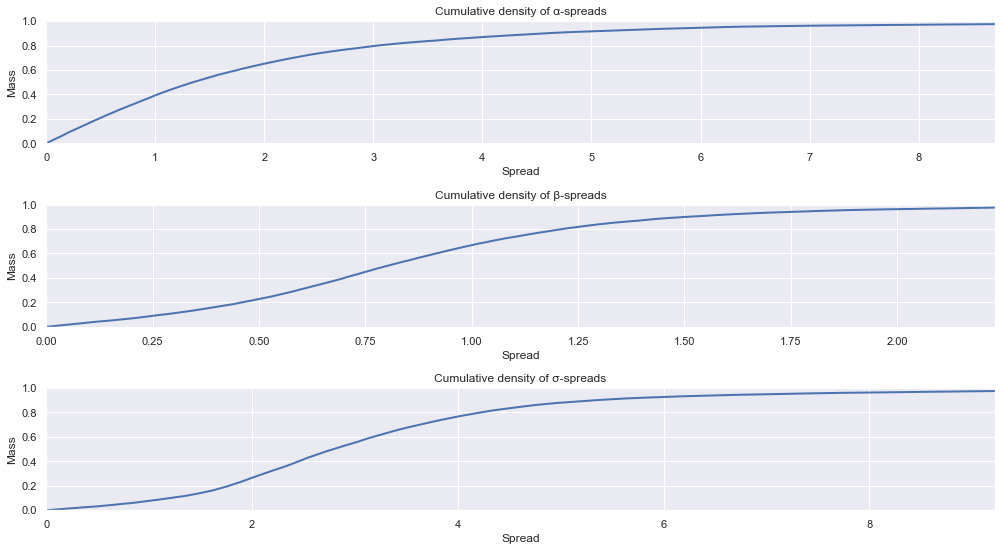

In [89]:
plt.figure(1, figsize=(17,9))

plt.subplot(311)
x = (alpha_0_monthly-alpha_1_monthly).abs().stack().sort_values()
y = np.linspace(0,1,(alpha_0_monthly-alpha_1_monthly).stack().shape[0])
plt.plot(x.values, y, linewidth=2)
plt.axis([0, x.quantile(0.975), 0, 1])
plt.title('Cumulative density of α-spreads')
plt.grid(True)
plt.ylabel('Mass')
plt.xlabel('Spread')

plt.subplot(312)
x = (beta_0_monthly-beta_1_monthly).abs().stack().sort_values()
y = np.linspace(0,1,(beta_0_monthly-beta_1_monthly).stack().shape[0])
plt.plot(x.values, y, linewidth=2)
plt.axis([0, x.quantile(0.975), 0, 1])
plt.title('Cumulative density of β-spreads')
plt.grid(True)
plt.ylabel('Mass')
plt.xlabel('Spread')

plt.subplot(313)
x = (sigma2_0_monthly**0.5-sigma2_1_monthly**0.5).abs().stack().sort_values()
y = np.linspace(0,1,(sigma2_0_monthly-sigma2_1_monthly).stack().shape[0])
plt.plot(x.values, y, linewidth=2)
plt.axis([0, x.quantile(0.975), 0, 1])
plt.title('Cumulative density of σ-spreads')
plt.grid(True)
plt.ylabel('Mass')
plt.xlabel('Spread')

plt.subplots_adjust(hspace=0.5)

To benchmark the regime-switching models, standard CAPM specifications with only one regime are estimated in the same data. The table below reports the frequency of cases where the Markov regime-switching models are preferred over the OLS specifications given various criteria. With eight free parameters instead of two, higher likelihood can easily be achieved. Therefore, better criteria take into account the number of parameters. Using an Akaike information criterion, in approximately half of the cases a two-regime specification achieves a better fit. If instead a Bayesian information criterion is used to select the model, only in a small number of cases the Markov model will be preferred.

In [20]:
ols_comparison = pd.DataFrame(index=['likelihood','AIC','BIC'], columns=['% HMM fits better than OLS'])
ols_comparison.iloc[0,0] = (likelihood_monthly > likelihood_ols_monthly).stack().sum() / ((likelihood_monthly.notna() & likelihood_ols_monthly.notna()).stack().sum())
ols_comparison.iloc[1,0] = (aic_monthly < aic_ols_monthly).stack().sum() / ((aic_monthly.notna() & aic_ols_monthly.notna()).stack().sum())
ols_comparison.iloc[2,0] = (bic_monthly < bic_ols_monthly).stack().sum() / ((bic_monthly.notna() & bic_ols_monthly.notna()).stack().sum())
ols_comparison

% HMM fits better than OLS
likelihood                     0.9964
AIC                            0.4509
BIC                            0.0788

If we compare the cross-sectional means of these statistics over time, we that there is time-series variation in how well the models match the data. However, the variation in the fit of the Hidden Markov Models (HMM) closely matches the variation of the OLS specifications. In periods where the HMM models do a relatively poorer job coincide with periods when standard one-regime CAPM regressions also have a decresed ability to explain returns.

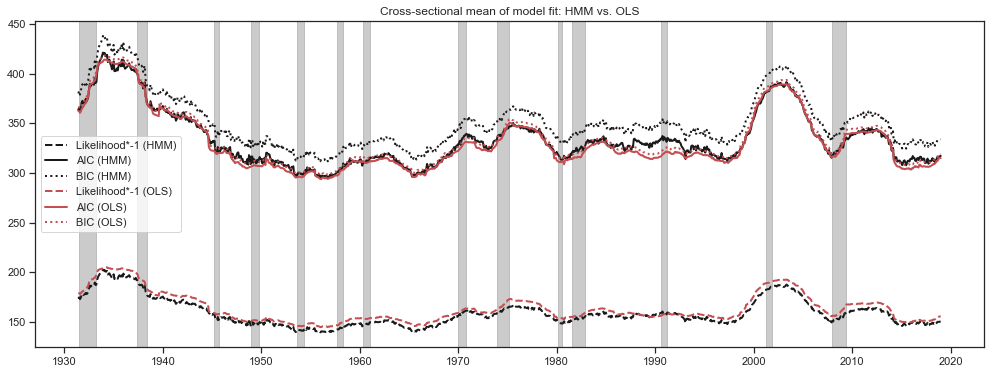

In [90]:
fig = plt.figure(1, figsize=(17,6))

with sns.axes_style('ticks'):
    plt.plot((-1*likelihood_monthly).mean(axis=1), linestyle='--', linewidth=2, color='k', label='Likelihood*-1 (HMM)')
    plt.plot(aic_monthly.mean(axis=1), linestyle='-', linewidth=2, color='k', label='AIC (HMM)')
    plt.plot(bic_monthly.mean(axis=1), linestyle=':', linewidth=2, color='k', label='BIC (HMM)')

    plt.plot((-1*likelihood_ols_monthly).mean(axis=1), linestyle='--', linewidth=2, color='r', label='Likelihood*-1 (OLS)')
    plt.plot(aic_ols_monthly.mean(axis=1), linestyle='-', linewidth=2, color='r', label='AIC (OLS)')
    plt.plot(bic_ols_monthly.mean(axis=1), linestyle=':', linewidth=2, color='r', label='BIC (OLS)')

    ax = plt.gca()
    add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])

    plt.grid(False)
    plt.legend()#loc="upper left", bbox_to_anchor=(1,1))#, edgecolor='k')
    plt.title('Cross-sectional mean of model fit: HMM vs. OLS')

<BarContainer object of 49 artists>

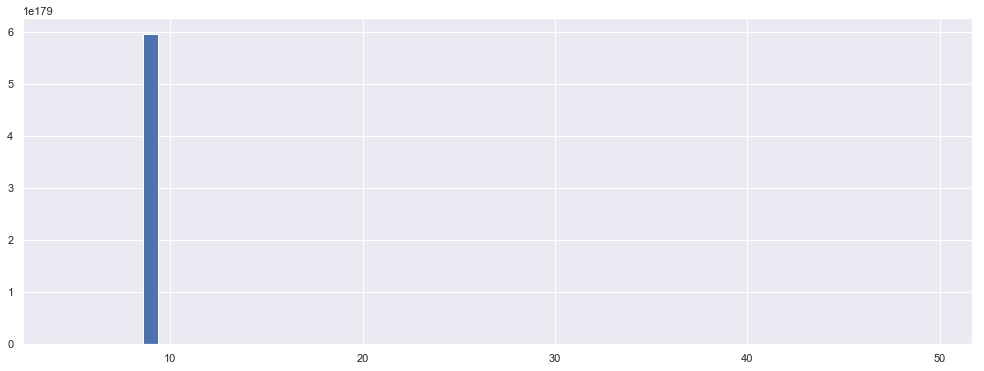

In [83]:
fig = plt.figure(1, figsize=(17,6))

#plt.bar(range(1,50), expected_duration_1.mean())
#prob_1_monthly
g = sns.barplot(x=industries.columns, y="survived", hue="sex", data=titanic,
                height=6, kind="bar", palette="muted")

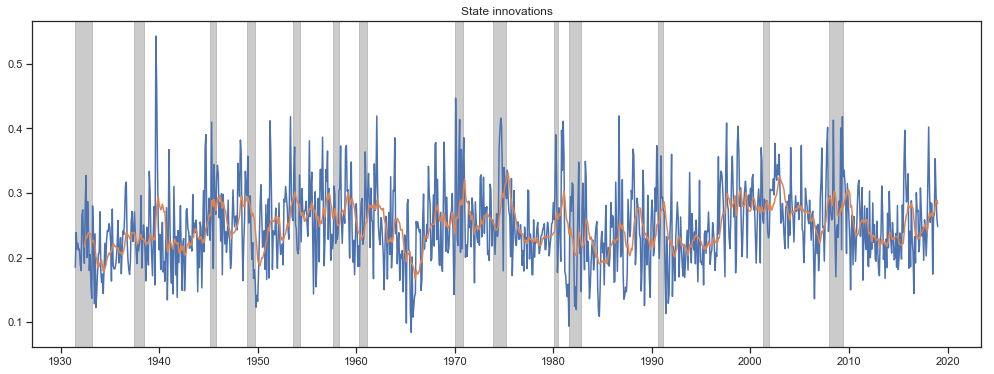

In [91]:
fig = plt.figure(1, figsize=(17,6))

with sns.axes_style('ticks'):
    plt.plot((prob_0_monthly).diff(1).abs().mean(axis=1).rolling(1).mean())
    plt.plot((prob_0_monthly).diff(1).abs().mean(axis=1).rolling(12).mean())
    
    ax = plt.gca()
    add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
    
    plt.title('State innovations')

### Correlation analysis of estimates from various models
To further evaluate the usefulness of the Hidden Markov Models (HMM), we calculate correlations of parameter estimates of such models with their standard CAPM counterparts. In particular, we consider the following:
* __Mean HMM__: The Markov switching model estimates weighted at the mean probabilities of the two regimes over the observation window.
* __Last HMM__: The Markov switching model estimates weighted at the regime-probabilities in the last month in the observation window.
* __Expected HMM at t-1__: The Markov switching model estimates weighted at the regime-probabilities in the last month in the observation window, iterated forward by one month through the transition matrix.
* __CAPM__: OLS estimates from CAPM regressions in the same observation window as in the HMM case.
* __Realised__: OLS estimates from CAPM regressions using 1 month of daily data.

Below therere three comparisons reported in the table:
* __Mean HMM vs. CAPM__: The first sanity check for the HMM models is to compare their estimates with the one-regime case of the standard CAPM. To have a sensible comparison, regime-parameters are weighted at the probabilites over the respective sample. Full-sample estimates obtained in such a way are considerably correlated to the CAPM equivalents.
* __Last HMM vs. Realised__: Next, we can ask if the most recent monthly estimates for each model are correlated with actually realised values. For that purpose, we correlate probability-weighted estimates at the end of each sample with realised CAPM estimates from daily data within the respective month. Correlations in this comparison indicate that HMM models do reasonably well in describing parameters realised within a given month.
* __Expected HMM at t-1 vs. Realised__: Last, we examine the predictive ability of HMM models with regards to realised volatility in the subsequent month. Instead of using static regime-probabilities, we can iterate one period forward by using the transition matrix. Such predicted regime probabilities are obtained purely from historical data and can therefore serve as a 1-month forecast. Compared to the previous contemperaneous relation, risk estimates are still similarly strongly correlated, whereas there is no predictive relation with regards to alpha.

The numbers in the table are Pearson correlation coefficients calculated over all time periods and assets.

In [67]:
corr_models_data = pd.DataFrame()
corr_models_data['Last HMM α'] = alpha_weighted_monthly.stack(dropna=False)
corr_models_data['Last HMM β'] = beta_weighted_monthly.stack(dropna=False)
corr_models_data['Last HMM σ²'] = sigma2_weighted_monthly.stack(dropna=False)
corr_models_data['realised α'] = realised_alpha.stack(dropna=False)
corr_models_data['realised β'] = realised_beta.stack(dropna=False)
corr_models_data['realised σ²'] = realised_sigma2.stack(dropna=False)
corr_models_data['Mean HMM α'] = mean_alpha_weighted_monthly.stack(dropna=False)
corr_models_data['Mean HMM β'] = mean_beta_weighted_monthly.stack(dropna=False)
corr_models_data['Mean HMM σ²'] = mean_sigma2_weighted_monthly.stack(dropna=False)
corr_models_data['CAPM α'] = alpha_ols_monthly.stack(dropna=False)
corr_models_data['CAPM β'] = beta_ols_monthly.stack(dropna=False)
corr_models_data['CAPM σ²'] = sigma2_ols_monthly.stack(dropna=False)
corr_models_data['expected α'] = alpha_forward1_monthly.shift(1).stack(dropna=False)
corr_models_data['expected β'] = beta_forward1_monthly.shift(1).stack(dropna=False)
corr_models_data['expected σ²'] = sigma2_forward1_monthly.shift(1).stack(dropna=False)

corr_models_table = pd.DataFrame(index=['Mean HMM α','Mean HMM β','Mean HMM σ²','Last HMM α','Last HMM β','Last HMM σ²','Expected HMM α (t-1)','Expected HMM β (t-1)','Expected HMM σ² (t-1)'], columns=['CAPM','Realised'])
corr_models_table.iloc[0,0] = corr_models_data.astype(float).corr()['Mean HMM α']['CAPM α']
corr_models_table.iloc[1,0] = corr_models_data.astype(float).corr()['Mean HMM β']['CAPM β']
corr_models_table.iloc[2,0] = corr_models_data.astype(float).corr()['Mean HMM σ²']['CAPM σ²']
corr_models_table.iloc[3,1] = corr_models_data.astype(float).corr()['Last HMM α']['realised α']
corr_models_table.iloc[4,1] = corr_models_data.astype(float).corr()['Last HMM β']['realised β']
corr_models_table.iloc[5,1] = corr_models_data.astype(float).corr()['Last HMM σ²']['realised σ²']
corr_models_table.iloc[6,1] = corr_models_data.astype(float).corr()['expected α']['realised α']
corr_models_table.iloc[7,1] = corr_models_data.astype(float).corr()['expected β']['realised β']
corr_models_table.iloc[8,1] = corr_models_data.astype(float).corr()['expected σ²']['realised σ²']
corr_models_table.iloc[3,0] = ''
corr_models_table.iloc[4,0] = ''
corr_models_table.iloc[5,0] = ''
corr_models_table.iloc[6,0] = ''
corr_models_table.iloc[7,0] = ''
corr_models_table.iloc[8,0] = ''
corr_models_table.iloc[0,1] = ''
corr_models_table.iloc[1,1] = ''
corr_models_table.iloc[2,1] = ''
corr_models_table

CAPM Realised
Mean HMM α            0.7828         
Mean HMM β            0.9225         
Mean HMM σ²           0.7165         
Last HMM α                     0.3145
Last HMM β                     0.3850
Last HMM σ²                    0.4621
Expected HMM α (t-1)           0.0381
Expected HMM β (t-1)           0.4383
Expected HMM σ² (t-1)          0.4249

In [23]:
corr_hmm_realised = pd.DataFrame()
corr_hmm_realised['probability-weighted α'] = alpha_weighted_monthly.stack(dropna=False)
corr_hmm_realised['probability-weighted β'] = beta_weighted_monthly.stack(dropna=False)
corr_hmm_realised['probability-weighted σ²'] = sigma2_weighted_monthly.stack(dropna=False)
corr_hmm_realised['realised α'] = realised_alpha.stack(dropna=False)
corr_hmm_realised['realised β'] = realised_beta.stack(dropna=False)
corr_hmm_realised['realised σ²'] = realised_sigma2.stack(dropna=False)
#corr_hmm_realised.astype(float).corr()

In [24]:
corr_hmm_realised_forward1 = pd.DataFrame()
corr_hmm_realised_forward1['expected α (t-1)'] = alpha_forward1_monthly.shift(1).stack(dropna=False)
corr_hmm_realised_forward1['expected β (t-1)'] = beta_forward1_monthly.shift(1).stack(dropna=False)
corr_hmm_realised_forward1['expected σ² (t-1)'] = sigma2_forward1_monthly.shift(1).stack(dropna=False)
corr_hmm_realised_forward1['realised α'] = realised_alpha.stack(dropna=False)
corr_hmm_realised_forward1['realised β'] = realised_beta.stack(dropna=False)
corr_hmm_realised_forward1['realised σ²'] = realised_sigma2.stack(dropna=False)
#corr_hmm_realised_forward1.astype(float).corr()

In [25]:
corr_hmm_ols = pd.DataFrame()
corr_hmm_ols['mean-probability-weighted α'] = mean_alpha_weighted_monthly.stack(dropna=False)
corr_hmm_ols['mean-probability-weighted β'] = mean_beta_weighted_monthly.stack(dropna=False)
corr_hmm_ols['mean-probability-weighted σ²'] = mean_sigma2_weighted_monthly.stack(dropna=False)
corr_hmm_ols['OLS α'] = alpha_ols_monthly.stack(dropna=False)
corr_hmm_ols['OLS β'] = beta_ols_monthly.stack(dropna=False)
corr_hmm_ols['OLS σ²'] = sigma2_ols_monthly.stack(dropna=False)
#corr_hmm_ols.astype(float).corr()

## Ambiguity measurement

Given the two-regime process, a measure of (expected) ambiguity in such a setting chould take into account:
* The (second-order) probabilities of being in either regime
* The distance between the two regime prior distributions

### Regime-Probabilities
Regarding the probabilities, we can obtain a proxy of ambiguity by considering the dispersion of regime probabilities. If we assume that the agents' perceived ambiguity is related to the uncertainty of being in either of the two regimes, we can construct a measure of ambiguity based on the estimated next-period probabilities of being in either of the states. In this framework, maximum ambiguity is reached when the two states are equally likely (p=0.5). On the other hand there is no ambiguity if all the probability mass is on one state (either p=0 or p=1). Therefore, measures could be:
* The L2-distance to the point of equal probability, scaled between 0 and 1:
$$\mathbb{D}_t\big[r^i_{t+1}\big] = 1-4 \, \big(P_t[S^i_{t+1} = 0]-0.5\big)^2$$
* Shannon entropy:
$$\mathbb{H}_t\big[r^i_{t+1}\big] = -\sum^1_{s_{t+1}=0} P_t[S^i_{t+1} = s_{t+1}] * log_2\big(P_t[S^i_{t+1} = s_{t+1}]\big)$$

Both measures take a value of one if both states are equally likely (maximum ambiguity), and zero if there is no ambiguity about the next period return distribution. Hence they take very similar values.

In [26]:
prob_distance_monthly = 1-4*(prob_0_forward1_monthly-0.5)**2
prob_entropy_monthly = -(prob_0_forward1_monthly*np.log2(prob_0_forward1_monthly.astype(float)) + prob_1_forward1_monthly*np.log2(prob_1_forward1_monthly.astype(float)))

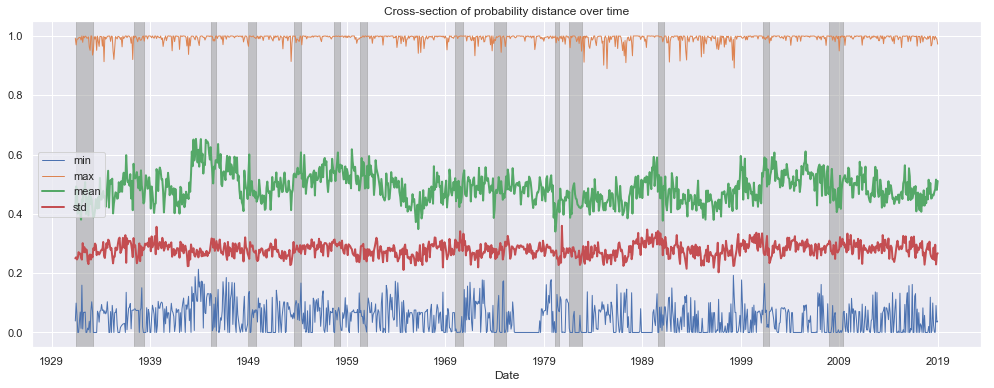

In [16]:
prob_distance_monthly.min(axis=1).plot(title='Cross-section of probability distance over time', figsize=(17,6), legend=True, linewidth=1, label='min')
prob_distance_monthly.max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#prob_distance_monthly.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
prob_distance_monthly.mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
prob_distance_monthly.std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

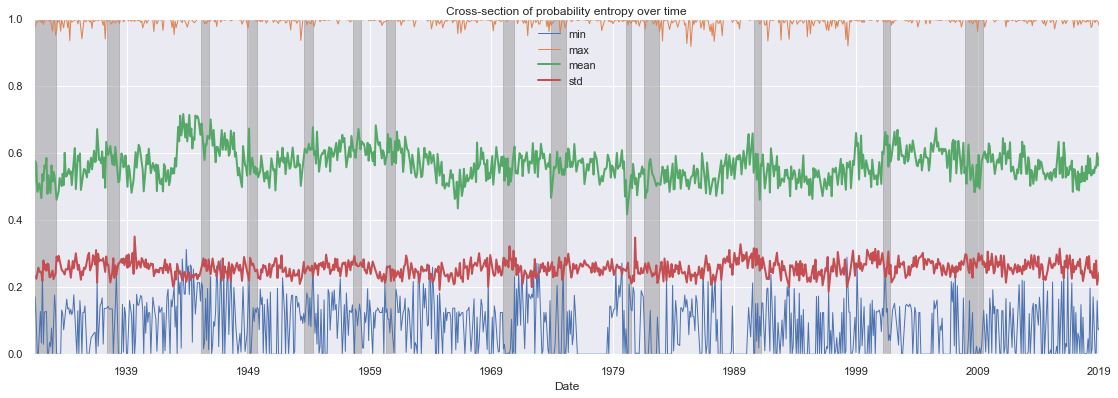

In [316]:
prob_entropy_monthly.min(axis=1).plot(title='Cross-section of probability entropy over time', figsize=(17,6), legend=True, linewidth=1, label='min')
prob_entropy_monthly.max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#prob_distance_monthly.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
prob_entropy_monthly.mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
prob_entropy_monthly.std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

### Regime-Dispersion
Regarding the distance between the two priors, we can calculate a distance measure between probability distributions, e.g:
* Kolmogorov-Smirnov distance:
$$\mathbb{KS}_t\big[r^i_{t+1}\big] = \sup_{r^i_{t+1}}\Big|\Phi_0(r^i_{t+1})-\Phi_1(r^i_{t+1})\Big| \quad \text{, where $\Phi(.)$ denotes the normal cumulative density function}$$
* Malalanobis distance (Bregman divergence):
$$\mathbb{M}_t\big[r^i_{t+1}\big] = \sqrt{\frac{(\mu^i_0-\mu^i_1)^2}{\frac{(\sigma^i_0)^2+(\sigma^i_1)^2}{2}}}$$
* Kullback-Leibler divergence (relative entropy):
$$\mathbb{R}_t\big[r^i_{t+1}\big] = ln\frac{\sigma^i_1}{\sigma^i_0} + \frac{(\sigma^i_0)^2+(\mu^i_0-\mu^i_1)^2}{2(\sigma^i_1)^2}-\frac{1}{2}$$

In order to parametrise the probability distributions (i.e. $\mu^i_{s_{t+1}}$ and $\sigma^i_{s_{t+1}}$), the previous estimates are used in combination with the full-sample average of the excess return on the market portfolio (as $\mathbb{E}_t\big[r^M_{t+1}\big]$).

In [29]:
%%time
kolmogorov_smirnov_monthly = pd.DataFrame(index=industries_monthly.index, columns=industries_monthly.columns)
for iMonth in range(0,len(industries_monthly.index)):
    for iAsset in range(0,len(industries_daily.columns)):
        kolmogorov_smirnov_monthly.iloc[iMonth,iAsset] = calc.calculate_kolmogorov_smirnov_distance((alpha_0_monthly.iloc[iMonth,iAsset]+beta_0_monthly.iloc[iMonth,iAsset]*expected_market_return), \
                                                                        (alpha_1_monthly.iloc[iMonth,iAsset]+beta_1_monthly.iloc[iMonth,iAsset]*expected_market_return), \
                                                                        (sigma2_0_monthly.iloc[iMonth,iAsset]**0.5), \
                                                                        (sigma2_1_monthly.iloc[iMonth,iAsset]**0.5))

Wall time: 3min 57s


In [30]:
malalanobis_distance_monthly = (((alpha_0_monthly+beta_0_monthly*expected_market_return)-(alpha_1_monthly+beta_1_monthly*expected_market_return))**2 / \
                                ((sigma2_0_monthly+sigma2_1_monthly)/2))**0.5
relative_entropy_monthly = np.log((sigma2_1_monthly**0.5/sigma2_0_monthly**0.5).astype(float)) + \
    ((sigma2_0_monthly + ((alpha_0_monthly+beta_0_monthly*expected_market_return)-(alpha_1_monthly+beta_1_monthly*expected_market_return))**2) / \
    (2*sigma2_1_monthly)) - 1/2

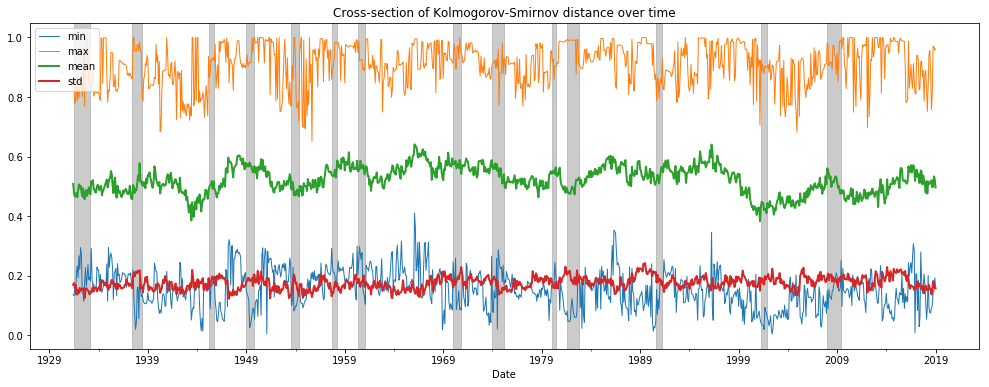

In [172]:
kolmogorov_smirnov_monthly.min(axis=1).plot(title='Cross-section of Kolmogorov-Smirnov distance over time', figsize=(17,6), legend=True, linewidth=1, label='min')
kolmogorov_smirnov_monthly.max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#ambiguity_daily.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
kolmogorov_smirnov_monthly.mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
kolmogorov_smirnov_monthly.std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

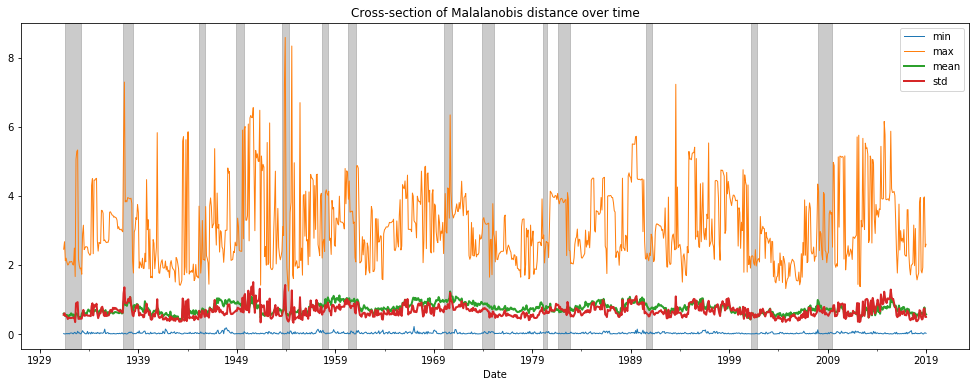

In [171]:
malalanobis_distance_monthly.abs().min(axis=1).plot(title='Cross-section of Malalanobis distance over time', figsize=(17,6), legend=True, linewidth=1, label='min')
malalanobis_distance_monthly.abs().max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#ambiguity_daily.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
malalanobis_distance_monthly.abs().mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
malalanobis_distance_monthly.abs().std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

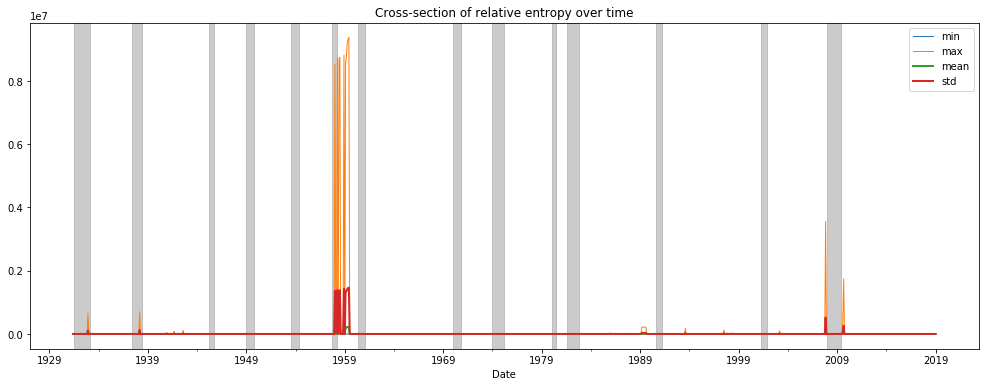

In [170]:
relative_entropy_monthly.min(axis=1).plot(title='Cross-section of relative entropy over time', figsize=(17,6), legend=True, linewidth=1, label='min')
relative_entropy_monthly.max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#ambiguity_daily.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
relative_entropy_monthly.mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
relative_entropy_monthly.std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

Note: Since relative entropy is not bounded from above, it takes some very large values in a few periods where parameters under one regime converge to extreme values. More, relative entropy is probably unsuitable since it is not symetric (it changes if the order of distributions changes).

### Measure Comparison

#### Summary Statistics

The following table is calculated using all observations across assets and time periods.

In [3]:
corr_measures_data = pd.DataFrame()
corr_measures_data['D'] = prob_distance_monthly.stack(dropna=False)
corr_measures_data['H'] = prob_entropy_monthly.stack(dropna=False)

corr_measures_data['KS'] = kolmogorov_smirnov_monthly.stack(dropna=False)
corr_measures_data['M'] = malalanobis_distance_monthly.stack(dropna=False)
corr_measures_data['R'] = relative_entropy_monthly.stack(dropna=False)

corr_measures_data['D x KS'] = corr_measures_data['D'] * corr_measures_data['KS']
corr_measures_data['D x M'] = corr_measures_data['D'] * corr_measures_data['M']
corr_measures_data['D x R'] = corr_measures_data['D'] * corr_measures_data['R']
corr_measures_data['H x KS'] = corr_measures_data['H'] * corr_measures_data['KS']
corr_measures_data['H x M'] = corr_measures_data['H'] * corr_measures_data['M']
corr_measures_data['H x R'] = corr_measures_data['H'] * corr_measures_data['R']

corr_measures_data.astype(float).describe()

D             H            KS             M             R  \
count  4.284200e+04  4.284200e+04  42842.000000  4.284200e+04  4.284200e+04   
mean   4.881195e-01  5.662233e-01      0.521589  7.452788e-01  2.313120e+03   
std    2.813255e-01  2.591369e-01      0.180200  6.936966e-01  1.371248e+05   
min    8.810730e-13  9.579162e-12      0.003994  2.124947e-07  5.014107e-05   
25%    2.530991e-01  3.579727e-01      0.397897  2.625927e-01  8.552099e-01   
50%    4.357804e-01  5.419544e-01      0.520686  5.723985e-01  1.559759e+00   
75%    7.196231e-01  7.870462e-01      0.644298  1.007757e+00  2.794244e+00   
max    1.000000e+00  1.000000e+00      1.000000  8.586279e+00  9.377634e+06   

             D x KS         D x M         D x R        H x KS         H x M  \
count  4.284200e+04  4.284200e+04  4.284200e+04  4.284200e+04  4.284200e+04   
mean   2.401110e-01  3.636835e-01  2.304958e+02  2.824432e-01  4.212313e-01   
std    1.495582e-01  4.249561e-01  1.519030e+04  1.470064e-01  4.525057e-01   
min    4.851736e-13  5.230151e-13  1.518859e-12  5.274882e-12  5.686302e-12   
25%    1.336103e-01  8.557217e-02  3.810019e-01  1.832115e-01  1.147599e-01   
50%    2.105653e-01  2.161397e-01  7.087538e-01  2.616332e-01  2.759227e-01   
75%    3.189943e-01  4.787467e-01  1.073224e+00  3.624486e-01  5.585443e-01   
max    9.936455e-01  4.862257e+00  2.377307e+06  9.940779e-01  4.864374e+00   

              H x R  
count  4.284200e+04  
mean   3.825588e+02  
std    2.365095e+04  
min    1.651327e-11  
25%    4.790348e-01  
50%    8.652637e-01  
75%    1.325568e+00  
max    3.288066e+06

Where:
* __D__: L2-distance
* __H__: Shannon entropy
* __KS__: Kolmogorov-Smirnov distance
* __M__: Malalanobis distance
* __R__: Relative entropy

Turning to summary statistics, we can confirm that relative entropy is in undesirable candidate for a measure. Another thing to point out here is that, while the variation in KS has a similar magnitude as D and H, the measure M varies a lot more and therefore dominates interactions.

#### Correlations

Given the similarity of some of the measures, we next look at correlations across measures of regime-probability dispersion, regime disperion, and interactions. Correlations are calculated using the full time-series and the full-cross-section.

In [75]:
corr_measures_data.astype(float).corr().where(np.triu(np.ones(corr_measures_data.shape[1])).astype(np.bool)).replace(np.nan,'')

D      H      KS       M       R  D x KS   D x M   D x R  H x KS  \
D      1.0000 0.9952 -0.2858 -0.0005 -0.0233  0.7648  0.5095 -0.0181  0.6749   
H             1.0000 -0.2761 -0.0042 -0.0261  0.7695  0.5045 -0.0197  0.6891   
KS                    1.0000  0.7313  0.0388  0.3034  0.4237  0.0341  0.4310   
M                             1.0000  0.0387  0.4163  0.7228  0.0356  0.4886   
R                                     1.0000 -0.0167 -0.0051  0.8107 -0.0148   
D x KS                                        1.0000  0.8373 -0.0103  0.9860   
D x M                                                 1.0000 -0.0002  0.8410   
D x R                                                         1.0000 -0.0074   
H x KS                                                                1.0000   
H x M                                                                          
H x R                                                                          

         H x M   H x R  
D       0.4389 -0.0201  
H       0.4383 -0.0220  
KS      0.4980  0.0366  
M       0.7977  0.0378  
R      -0.0011  0.8853  
D x KS  0.7997 -0.0122  
D x M   0.9911 -0.0013  
D x R   0.0042  0.9899  
H x KS  0.8208 -0.0095  
H x M   1.0000  0.0031  
H x R           1.0000

Where:
* __D__: L2-distance
* __H__: Shannon entropy
* __KS__: Kolmogorov-Smirnov distance
* __M__: Malalanobis distance
* __R__: Relative entropy

With a correlation above 0.99, the choice between D and H is a pure matter of preference. 
Given the outlier-driven structure of R, the distance between regimes should be described by either KS or M. Both are again highly correlated, whereas M appears to be more independent from the measures of probability dispersion and dominates them when interacted due to its larger variation.

### Ambiguity proxy

Taking into account both components (probabilities and distributions), we can create a combined measure by interacting the two. This will be the proxy for ambiguity in what follows. Given the property that both measures are bounded between 0 and 1 and the evidence from the previous part, a combination of the L2-distance and the Kolmogorov-Smirnov distance currently serves as ambiguity proxy:
$$\mathbb{A}_t\big[r^i_{t+1}\big] = \mathbb{D}_t\big[r^i_{t+1}\big] \times \mathbb{KS}_t\big[r^i_{t+1}\big]$$


In [36]:
ambiguity_monthly = prob_distance_monthly * kolmogorov_smirnov_monthly

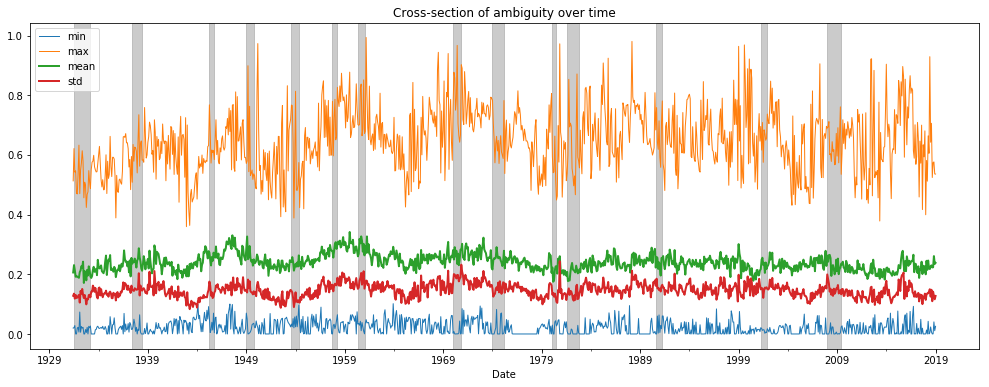

In [173]:
ambiguity_monthly.min(axis=1).plot(title='Cross-section of ambiguity over time', figsize=(17,6), legend=True, linewidth=1, label='min')
ambiguity_monthly.max(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='max')
#ambiguity_daily.median(axis=1).plot(figsize=(17,6), legend=True, linewidth=1, label='median')
ambiguity_monthly.mean(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='mean')
ambiguity_monthly.std(axis=1).plot(figsize=(17,6), legend=True, linewidth=2, label='std')
ax = plt.gca()
add_recession_bars(ax, startdate=prob_0_monthly.index[window_length_monthly])
plt.show()

## Analysis

### Pooled Regression

To establish whether the ambiguity measure predicts returns on the subsequent period, we run pooled regressions of the following form:
$$ r_{t+1}^i = \beta_0 + \beta_1 \, \mathbb{A}_t\big[r^i_{t+1}\big] + \gamma \, X^i_t + \varepsilon_{t+1}^i $$

First, we consider total regime ambiguity $\mathbb{A}_t\big[r^i_{t+1}\big]$ as the independent variable of interest. We can then also consider the contributors probability distance $\mathbb{D}_t\big[r^i_{t+1}\big]$ and Kolmogorov-Smirnov distance $\mathbb{KS}_t\big[r^i_{t+1}\big]$ separately to decompose the effects in alternative specifications.

$X^i_t$ is a set of conditioning variables. After considering univariate regressions of returns on ambiguity as depicted in the scatter plot below, we include the expected first two moments of the mixed prior distribution to contrast the effect of ambiguity with that of risk. These expected moments incorporate the expected parameters obtained from the Markov chain of regime probabilities. In another specification we can also directly include expected $\alpha$, $\beta$ and $\sigma^2$. Additionally, the Akaike information criterion of the corresponding two-regime model serves to control for misspecified models. Lastly, we condition on estimates from intra-month CAPM regressions to account for standard CAPM risk metrics.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


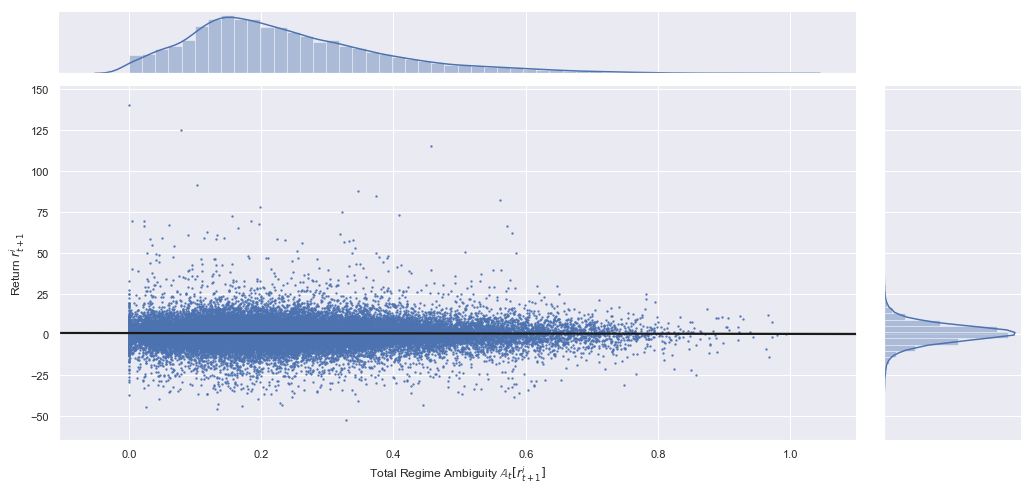

In [72]:
#fig = plt.figure(1, figsize=(17,7))

joint = sns.jointplot(x='expected ambiguity', y='return', data=X.astype(float), dropna=True, kind="reg", joint_kws={'color':'b','scatter_kws':{'s': 2},'line_kws':{'color':'k'}})
joint.fig.set_figwidth(16)
joint.fig.set_figheight(7)

plt.xlabel("Total Regime Ambiguity $\mathbb{A}_t[r^i_{t+1}]$")
plt.ylabel("Return $r^i_{t+1}$");

Below are parameter estimates and standard errors (Driscoll-Kraay) from a various regression specifications. Variables in the regressions are cross-sectionally standardised.

It seems that the effect of ambiguity mainly stems from second-order probabilities, and the contribution of regime dispersion is weak. Conditioning on various sets of variables appears not to significantly impact the negative predictive relation of expected return ambiguity and returns.

In [40]:
rowindex = pd.DataFrame(index=industries_monthly.index,columns=range(49)).T.stack(dropna=False).index

In [41]:
# LHS variable
Y = pd.DataFrame(index=rowindex)
Y['return'] = industries_monthly.T.stack(dropna=False).values

In [42]:
# RHS variables
X = pd.DataFrame(index=rowindex)
X['probability distance'] = prob_distance_monthly.shift(1).T.stack(dropna=False).values
X['probability entropy'] = prob_entropy_monthly.shift(1).T.stack(dropna=False).values
X['kolmogorov-smirnov distance'] = kolmogorov_smirnov_monthly.shift(1).T.stack(dropna=False).values
X['malalanobis distance'] = malalanobis_distance_monthly.shift(1).T.stack(dropna=False).values
X['relative entropy'] = relative_entropy_monthly.shift(1).T.stack(dropna=False).values
X['expected ambiguity'] = ambiguity_monthly.shift(1).T.stack(dropna=False).values

X['expected return'] = expected_mean.shift(1).T.stack(dropna=False).values
X['expected total variance'] = expected_variance.shift(1).T.stack(dropna=False).values

X['alpha'] = alpha_forward1_monthly.shift(1).T.stack(dropna=False).values
X['beta'] = beta_forward1_monthly.shift(1).T.stack(dropna=False).values
X['sigma2'] = sigma2_forward1_monthly.shift(1).T.stack(dropna=False).values
X['aic'] = aic_monthly.shift(1).T.stack(dropna=False).values

X['real_beta'] = realised_beta.shift(1).T.stack(dropna=False).values
X['real_alpha'] = realised_alpha.shift(1).T.stack(dropna=False).values
X['real_sigma2'] = realised_sigma2.shift(1).T.stack(dropna=False).values

In [43]:
# interactions
X['exp ambiguity x exp return'] = X['expected ambiguity'] * X['expected return']
X['exp ambiguity x exp total variance'] = X['expected ambiguity'] * X['expected total variance']

X['exp ambiguity x beta'] = X['expected ambiguity'] * X['beta']
X['exp ambiguity x alpha'] = X['expected ambiguity'] * X['alpha']
X['exp ambiguity x sigma2'] = X['expected ambiguity'] * X['sigma2']
X['exp ambiguity x aic'] = X['expected ambiguity'] * X['aic']

In [19]:
X = sm.add_constant(X)
X = X.join(Y)

In [45]:
reg1 = lm.PanelOLS(Y,X[['const','expected ambiguity']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg2 = lm.PanelOLS(Y,X[['const','expected ambiguity', 'expected return', 'expected total variance']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg3 = lm.PanelOLS(Y,X[['const','expected ambiguity', 'alpha', 'beta', 'sigma2', 'aic']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg4 = lm.PanelOLS(Y,X[['const','expected ambiguity', 'real_alpha', 'real_beta', 'real_sigma2']], entity_effects=False, time_effects=False).fit(cov_type='kernel')

reg5 = lm.PanelOLS(Y,X[['const','probability distance']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg6 = lm.PanelOLS(Y,X[['const','probability distance', 'expected return', 'expected total variance']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg7 = lm.PanelOLS(Y,X[['const','probability distance', 'alpha', 'beta', 'sigma2','aic']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg8 = lm.PanelOLS(Y,X[['const','probability distance', 'real_alpha', 'real_beta', 'real_sigma2']], entity_effects=False, time_effects=False).fit(cov_type='kernel')

reg9 = lm.PanelOLS(Y,X[['const','kolmogorov-smirnov distance']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg10 = lm.PanelOLS(Y,X[['const','kolmogorov-smirnov distance', 'expected return', 'expected total variance']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg11 = lm.PanelOLS(Y,X[['const','kolmogorov-smirnov distance', 'alpha', 'beta', 'sigma2','aic']], entity_effects=False, time_effects=False).fit(cov_type='kernel')
reg12 = lm.PanelOLS(Y,X[['const','kolmogorov-smirnov distance', 'real_alpha', 'real_beta', 'real_sigma2']], entity_effects=False, time_effects=False).fit(cov_type='kernel')

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [46]:
reg_table = pd.DataFrame(index=['constant', '' , '$\mathbb{A}_t[r^i_{t+1}]$', '', '$\mathbb{D}_t[r^i_{t+1}]$', '', '$\mathbb{KS}_t[r^i_{t+1}]$', '', '$\mathbb{E}_t[r^i_{t+1}]$', '', \
                                '$\mathbb{V}_t[r^i_{t+1}]$', '', 'expected α$_{t+1}$', '', 'expected β$_{t+1}$', '', 'expected σ$^2_{t+1}$', '', 'AIC', '', \
                                'realised α$_t$', '', 'realised β$_t$', '', 'realised σ$^2_t$', '', 'R²', 'N'], columns=range(1,13))

reg_table.iloc[[0,2],0] = reg1.params.values
reg_table.iloc[[1,3],0] = reg1.std_errors.values
reg_table.iloc[[26],0] = reg1.rsquared
reg_table.iloc[[27],0] = reg1.nobs

reg_table.iloc[[0,2,8,10],1] = reg2.params.values
reg_table.iloc[[1,3,9,11],1] = reg2.std_errors.values
reg_table.iloc[[26],1] = reg2.rsquared
reg_table.iloc[[27],1] = reg2.nobs

reg_table.iloc[[0,2,12,14,16,18],2] = reg3.params.values
reg_table.iloc[[1,3,13,15,17,19],2] = reg3.std_errors.values
reg_table.iloc[[26],2] = reg3.rsquared
reg_table.iloc[[27],2] = reg3.nobs

reg_table.iloc[[0,2,20,22,24],3] = reg4.params.values
reg_table.iloc[[1,3,21,23,25],3] = reg4.std_errors.values
reg_table.iloc[[26],3] = reg4.rsquared
reg_table.iloc[[27],3] = reg4.nobs

reg_table.iloc[[0,4],4] = reg5.params.values
reg_table.iloc[[1,5],4] = reg5.std_errors.values
reg_table.iloc[[26],4] = reg5.rsquared
reg_table.iloc[[27],4] = reg5.nobs

reg_table.iloc[[0,4,8,10],5] = reg6.params.values
reg_table.iloc[[1,5,9,11],5] = reg6.std_errors.values
reg_table.iloc[[26],5] = reg6.rsquared
reg_table.iloc[[27],5] = reg6.nobs

reg_table.iloc[[0,4,12,14,16,18],6] = reg7.params.values
reg_table.iloc[[1,5,13,15,17,19],6] = reg7.std_errors.values
reg_table.iloc[[26],6] = reg7.rsquared
reg_table.iloc[[27],6] = reg7.nobs

reg_table.iloc[[0,4,20,22,24],7] = reg8.params.values
reg_table.iloc[[1,5,21,23,25],7] = reg8.std_errors.values
reg_table.iloc[[26],7] = reg8.rsquared
reg_table.iloc[[27],7] = reg8.nobs

reg_table.iloc[[0,6],8] = reg9.params.values
reg_table.iloc[[1,7],8] = reg9.std_errors.values
reg_table.iloc[[26],8] = reg9.rsquared
reg_table.iloc[[27],8] = reg9.nobs

reg_table.iloc[[0,6,8,10],9] = reg10.params.values
reg_table.iloc[[1,7,9,11],9] = reg10.std_errors.values
reg_table.iloc[[26],9] = reg10.rsquared
reg_table.iloc[[27],9] = reg10.nobs

reg_table.iloc[[0,6,12,14,16,18],10] = reg11.params.values
reg_table.iloc[[1,7,13,15,17,19],10] = reg11.std_errors.values
reg_table.iloc[[26],10] = reg11.rsquared
reg_table.iloc[[27],10] = reg11.nobs

reg_table.iloc[[0,6,20,22,24],11] = reg12.params.values
reg_table.iloc[[1,7,21,23,25],11] = reg12.std_errors.values
reg_table.iloc[[26],11] = reg12.rsquared
reg_table.iloc[[27],11] = reg12.nobs

reg_table.replace(np.nan, '')

1       2       3       4       5       6   \
constant                    0.8670  0.7292  1.1416  0.6897  0.8570  0.7156   
                            0.2069  0.1977  0.6182  0.1989  0.2075  0.1985   
$\mathbb{A}_t[r^i_{t+1}]$  -0.4953 -0.5889 -0.5601 -0.5287                   
                            0.3269  0.3540  0.3569  0.3361                   
$\mathbb{D}_t[r^i_{t+1}]$                                  -0.2231 -0.2573   
                                                            0.1588  0.1695   
$\mathbb{KS}_t[r^i_{t+1}]$                                                   
                                                                             
$\mathbb{E}_t[r^i_{t+1}]$           0.1127                          0.1118   
                                    0.0877                          0.0877   
$\mathbb{V}_t[r^i_{t+1}]$           0.0035                          0.0034   
                                    0.0035                          0.0035   
expected α$_{t+1}$                          0.1276                           
                                            0.0854                           
expected β$_{t+1}$                         -0.1367                           
                                            0.2414                           
expected σ$^2_{t+1}$                        0.0066                           
                                            0.0044                           
AIC                                        -0.0008                           
                                            0.0022                           
realised α$_t$                                      0.8136                   
                                                    0.4276                   
realised β$_t$                                      0.1534                   
                                                    0.1378                   
realised σ$^2_t$                                    0.0278                   
                                                    0.0254                   
R²                          0.0001  0.0007  0.0009  0.0013  0.0001  0.0007   
N                            42773   42773   42773   42771   42773   42773   

                                7       8       9       10      11      12  
constant                    1.0984  0.6810  0.7641  0.6183  1.0360  0.5935  
                            0.6224  0.1990  0.2410  0.2244  0.6597  0.2293  
$\mathbb{A}_t[r^i_{t+1}]$                                                   
                                                                            
$\mathbb{D}_t[r^i_{t+1}]$  -0.2944 -0.2296                                  
                            0.1914  0.1634                                  
$\mathbb{KS}_t[r^i_{t+1}]$                 -0.0308 -0.0527  0.0232 -0.0590  
                                            0.2683  0.2663  0.2466  0.2608  
$\mathbb{E}_t[r^i_{t+1}]$                           0.1150                  
                                                    0.0876                  
$\mathbb{V}_t[r^i_{t+1}]$                           0.0033                  
                                                    0.0035                  
expected α$_{t+1}$          0.1269                          0.1266          
                            0.0853                          0.0857          
expected β$_{t+1}$         -0.1587                         -0.1164          
                            0.2448                          0.2383          
expected σ$^2_{t+1}$        0.0064                          0.0067          
                            0.0044                          0.0044          
AIC                        -0.0005                         -0.0010          
                            0.0022                          0.0021          
realised α$_t$                      0.8126                          0.8131  
                                    0.4273                          0.4281 

### Portfolio Sorts

#### Functions

In [46]:
def sort_portfolios(returns, ranking_variable, n_portfolios, lags=1, return_assets=False):
    # align periods
    sorting_variable = ranking_variable.shift(lags)
    
    # set up parameters
    [t,n] = returns.shape
    include = returns.notna() & sorting_variable.notna()
    n_period = include.sum(axis=1)

    # sort assets
    returns[~include] = np.nan
    sorting_variable[~include] = np.nan
    cutoff_ranks = np.dot(n_period.values.reshape(t,1)/n_portfolios,np.arange(n_portfolios+1).reshape(1,n_portfolios+1)).round()
    asset_ranks = sorting_variable.rank(axis=1)
    
    # set up output frames
    portfolio_returns = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_assets = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_mapping = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    # calculate outputs
    for i_portfolio in range(0,n_portfolios):
        lower = cutoff_ranks[:,i_portfolio].reshape(t,1).repeat(n, axis=1)
        upper = cutoff_ranks[:,i_portfolio+1].reshape(t,1).repeat(n, axis=1)
        portfolio_returns[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].mean(axis=1)
        portfolio_assets[i_portfolio+1] = ((asset_ranks>lower) & (asset_ranks<=upper)).sum(axis=1)
        portfolio_mapping[(asset_ranks>lower) & (asset_ranks<=upper)] = i_portfolio
    
    # outputs
    if return_assets == False:
        return portfolio_returns
    else:
        return portfolio_returns, portfolio_assets, portfolio_mapping

In [50]:
def double_sort_portfolios(returns, ranking_variable_1, ranking_variable_2, n_portfolios_1, n_portfolios_2, lags_1=1, lags_2=1, return_assets=False):
    # identify missing values
    exclude = returns.isna() | ranking_variable_1.shift(lags_1).isna() | ranking_variable_2.shift(lags_2).isna()
    returns[exclude] = np.nan
    
    # first sort
    portfolio_mapping_1 = sort_portfolios(returns, ranking_variable_1, n_portfolios_1, lags_1, return_assets=True)[2]
    
    # second sorts
    portfolio_mapping_2 = pd.DataFrame(0, index=portfolio_mapping_1.index, columns=portfolio_mapping_1.columns)
    for i_portfolio_2 in range(0,n_portfolios_2):
        subportfolio_returns = returns[portfolio_mapping_1 == i_portfolio_2]
        portfolio_mapping_2 += (sort_portfolios(subportfolio_returns, ranking_variable_2, n_portfolios_2, lags_2, return_assets=True)[2]).fillna(0)
    portfolio_mapping_2[exclude] = np.nan
    
    # combined sort
    portfolio_mapping = portfolio_mapping_1*n_portfolios_1 + portfolio_mapping_2
    
    # set up output frames
    portfolio_returns = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    portfolio_assets = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    
    # calculate outputs
    for i_portfolio_all in range(0,n_portfolios_1*n_portfolios_2):
        portfolio_returns.iloc[:,i_portfolio_all] = returns[portfolio_mapping == i_portfolio_all].mean(axis=1)
        portfolio_assets.iloc[:,i_portfolio_all] = (portfolio_mapping == i_portfolio_all).sum(axis=1)
        
    # outputs
    if return_assets == False:
        return portfolio_returns
    else:
        return portfolio_returns, portfolio_assets, portfolio_mapping

#### Single Sorts

Portfolios are sorted based on the combined ambiguity measure, where Portfolio '1' is the low-ambiguity portfolio. Period-asset pairs where a simple one-regime CAPM has a better fit than the two-regime CAPM based on the AIC criterion are excluded from the sorts.

Although the high-minus-low ambuguity portfolio has a negative return consistent with the previous section, it only returns about 1% per year and its return is not significant using a regular standard errors.

In [239]:
n_portfolios = 5
portfolio_returns, portfolio_assets, portfolio_mapping = sort_portfolios(industries_monthly[aic_monthly<aic_ols_monthly],ambiguity_monthly,n_portfolios,return_assets=True)
portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]

In [240]:
spreading_portfolio_returns = pd.DataFrame()
spreading_portfolio_returns['AMP (all)'] = portfolio_returns['5-1']

In [241]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['T'] = portfolio_returns.count()
sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

In [242]:
sorted_portfolios.replace(np.nan,'')

mean    std     T average N  t-stat  return p.a.  volatility p.a.  \
1    0.9126 6.2963  1051    3.5300  4.6991      10.9516          21.8109   
2    0.9802 6.3536  1051    3.5214  5.0014      11.7622          22.0095   
3    0.7307 6.2325  1051    3.5442  3.8010       8.7687          21.5900   
4    0.7978 6.0887  1051    3.5214  4.2478       9.5734          21.0919   
5    0.8299 6.7409  1051    3.5300  3.9913       9.9589          23.3511   
5-1 -0.0827 3.9872  1051           -0.6726      -0.9927          13.8122   

         SR  
1    0.5021  
2    0.5344  
3    0.4061  
4    0.4539  
5    0.4265  
5-1 -0.0719

#### Double Sorts

Portfolios are sorted first on expected betas, then on ambiguity. Period-asset pairs where a simple one-regime CAPM has a better fit than the two-regime CAPM based on the AIC criterion are excluded from the sorts.

For example, portfolio _'1,3'_ refers to the low-beta, high-ambiguity portfolio.

Although returns on the spreading portfolios do not turn statistically significant when double-sorted, the pattern of increasing return spread with increasing beta is visible.

In [27]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(industries_monthly[aic_monthly<aic_ols_monthly], beta_forward1_monthly, ambiguity_monthly, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

NameError: name 'spreading_portfolio_returns' is not defined

In [ ]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [ ]:
double_sorted_portfolios.replace(np.nan,'')

The same pattern repeats when using double-sorts based on expected variance and expected ambiguity. 

(Note: Portfolio _'1,3'_ now refers to the low-variance, high-ambiguity portfolio)

In [247]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(industries_monthly[aic_monthly<aic_ols_monthly], expected_variance, ambiguity_monthly, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low variance)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium variance)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high variance)'] = double_portfolio_returns['3,3 - 3,1']

In [248]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [249]:
double_sorted_portfolios.replace(np.nan,'')

mean    std     T average N  t-stat  return p.a.  \
1,1        0.7311 5.4502  1051    1.9610  4.3489       8.7735   
1,2        0.6836 5.9676  1050    1.9676  3.7117       8.2028   
1,3        0.7179 5.2250  1051    1.9610  4.4545       8.6152   
2,1        0.9840 6.6912  1051    1.9610  4.7675      11.8081   
2,2        0.7914 6.7377  1048    1.9552  3.8026       9.4973   
2,3        0.9275 6.6992  1051    1.9610  4.4885      11.1303   
3,1        1.0768 8.2939  1051    1.9610  4.2089      12.9212   
3,2        0.7591 7.6580  1050    1.9676  3.2121       9.1095   
3,3        0.9129 8.3275  1051    1.9610  3.5538      10.9545   
1,3 - 1,1 -0.0132 3.4188  1051           -0.1251      -0.1583   
2,3 - 2,1 -0.0565 4.5550  1051           -0.4020      -0.6778   
3,3 - 3,1 -0.1639 6.8424  1051           -0.7765      -1.9667   

           volatility p.a.      SR  
1,1                18.8802  0.4647  
1,2                20.6724  0.3968  
1,3                18.1000  0.4760  
2,1                23.1791  0.5094  
2,2                23.3402  0.4069  
2,3                23.2067  0.4796  
3,1                28.7310  0.4497  
3,2                26.5280  0.3434  
3,3                28.8472  0.3797  
1,3 - 1,1          11.8431 -0.0134  
2,3 - 2,1          15.7789 -0.0430  
3,3 - 3,1          23.7028 -0.0830

When sorting on expected idiosyncratic varaince and then on ambiguity, results look very similar to the beta-ambiguity sorts.

(Note: Portfolio _'1,3'_ now refers to the low-idiosyncratic variance, high-ambiguity portfolio)

In [295]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(industries_monthly[aic_monthly<aic_ols_monthly], sigma2_forward1_monthly, ambiguity_monthly, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low variance)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium variance)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high variance)'] = double_portfolio_returns['3,3 - 3,1']

In [296]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [297]:
double_sorted_portfolios.replace(np.nan,'')

mean    std     T average N  t-stat  return p.a.  \
1,1        0.6770 5.4245  1051    1.9610  4.0461       8.1242   
1,2        0.7107 5.7799  1050    1.9676  3.9842       8.5280   
1,3        0.7525 5.4902  1051    1.9610  4.4435       9.0302   
2,1        0.8933 6.6336  1051    1.9610  4.3657      10.7198   
2,2        0.8768 6.9110  1048    1.9552  4.1072      10.5218   
2,3        0.8616 6.9010  1051    1.9610  4.0478      10.3398   
3,1        1.1660 8.1426  1051    1.9610  4.6423      13.9918   
3,2        0.7973 7.6692  1050    1.9676  3.3688       9.5678   
3,3        0.8859 8.4299  1051    1.9610  3.4068      10.6304   
1,3 - 1,1  0.0755 3.5181  1051            0.6958       0.9060   
2,3 - 2,1 -0.0317 4.5435  1051           -0.2260      -0.3800   
3,3 - 3,1 -0.2801 6.9986  1051           -1.2976      -3.3614   

           volatility p.a.      SR  
1,1                18.7911  0.4323  
1,2                20.0223  0.4259  
1,3                19.0187  0.4748  
2,1                22.9796  0.4665  
2,2                23.9405  0.4395  
2,3                23.9059  0.4325  
3,1                28.2068  0.4960  
3,2                26.5670  0.3601  
3,3                29.2020  0.3640  
1,3 - 1,1          12.1870  0.0743  
2,3 - 2,1          15.7390 -0.0241  
3,3 - 3,1          24.2439 -0.1387

#### 4-Factor regressions

Finally, we regress the returns on the Ambiguity-minus-Pure-Risk-Portfolios (AMP) on standard return factors. Some of the coefficients are significant. However, loadings are relatively small and R² are generally low.

In [2]:
fourfact_table = pd.DataFrame(index=['constant', '' , 'Mkt-RF', '', 'SMB', '', 'HML', '', 'Mom', '', 'R²', 'N'], columns=spreading_portfolio_returns.columns)

NameError: name 'spreading_portfolio_returns' is not defined

In [281]:
for iAMP in spreading_portfolio_returns.columns:
    reg = sm.OLS(spreading_portfolio_returns[iAMP],sm.add_constant(factors_monthly.drop(['RF'], axis=1)), missing='drop').fit()
    
    fourfact_table.loc[:,iAMP].iloc[[0,2,4,6,8]] = reg.params.values
    fourfact_table.loc[:,iAMP].iloc[[1,3,5,7,9]] = reg.bse.values
    fourfact_table.loc[:,iAMP].iloc[[10]] = reg.rsquared
    fourfact_table.loc[:,iAMP].iloc[[11]] = int(reg.nobs)

In [282]:
fourfact_table.replace(np.nan,'')

AMP (all)  AMP (low beta)  AMP (medium beta)  AMP (high beta)  \
constant    -0.1072          0.0474            -0.1356          -0.3328   
             0.1259          0.1341             0.1536           0.1901   
Mkt-RF      -0.0181         -0.0491            -0.0377           0.0709   
             0.0259          0.0276             0.0316           0.0391   
SMB          0.2244          0.1005             0.2286           0.0414   
             0.0404          0.0430             0.0493           0.0610   
HML         -0.0326          0.0870             0.1134          -0.1705   
             0.0383          0.0408             0.0467           0.0578   
Mom         -0.0145         -0.0200             0.0297           0.0698   
             0.0295          0.0315             0.0360           0.0446   
R²           0.0303          0.0124             0.0271           0.0164   
N         1051.0000       1051.0000          1051.0000        1051.0000   

          AMP (low variance)  AMP (medium variance)  AMP (high variance)  
constant              0.0165                -0.0165              -0.2081  
                      0.1090                 0.1454               0.2178  
Mkt-RF               -0.0597                 0.0030              -0.1018  
                      0.0224                 0.0299               0.0448  
SMB                  -0.0063                 0.0286               0.1529  
                      0.0350                 0.0467               0.0699  
HML                   0.0081                -0.1251               0.0265  
                      0.0332                 0.0442               0.0663  
Mom                   0.0155                -0.0010               0.1056  
                      0.0256                 0.0341               0.0511  
R²                    0.0101                 0.0089               0.0139  
N                  1051.0000              1051.0000            1051.0000

In [57]:
import dill
dill.dump_session('test.db')

In [1]:
import dill
dill.load_session('test.db')